In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base= automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\prudh\AppData\Local\Temp\ipykernel_46036\2594721594.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station=Base.classes.station


In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [13]:
# Find the most recent date in the data set.
recent_date = session.query(func.max(Measurement.date)).first()[0]

print(recent_date)

2017-08-23


In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
results_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
str_date=list(np.ravel(results_date))[0]
latest_date=dt.datetime.strptime(str_date,"%Y-%m-%d")
year_back=latest_date-dt.timedelta(days=366)
# Perform a query to retrieve the data and precipitation scores

results=session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.asc()).\
        filter(Measurement.date>=year_back).all()
# Save the query results as a Pandas DataFrame. Explicitly set the column names
df_results=pd.DataFrame(results)
df_results=df_results.rename(columns={"prcp":"precipitation"})
# Sort the dataframe by date
df_results.sort_values(by=['date'], ascending=True)
df_results=df_results.dropna()
df_results=df_results.reset_index(drop=True)

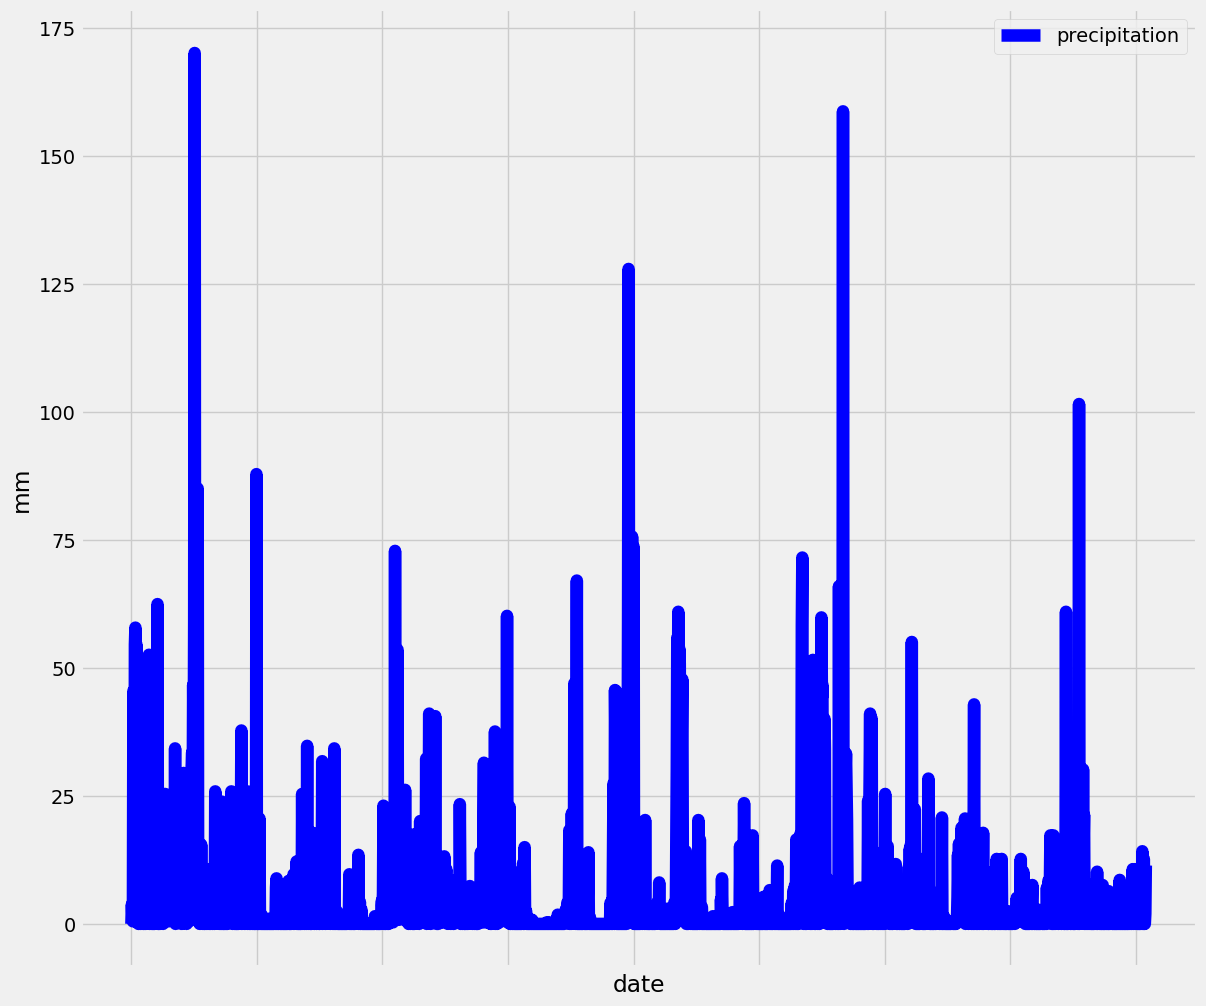

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
ax=df_results.plot(color='b',figsize=(12,10),legend=True,linewidth=9.0,grid=True)
#Removing xticks
plt.setp(ax.get_xticklabels(), visible=False)
plt.tight_layout()
plt.xlabel("date")
plt.ylabel("mm")
plt.show()




In [19]:
# Use Pandas to calculate the summary statistics for the precipitation data
df_results.describe()

,precipitation
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [20]:
# Design a query to calculate the total number of stations in the dataset
station_count=session.query(func.count(Station.id)).all()
station_count

[(9,)]

In [21]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

station_Measurment_join=session.query(Measurement.station,func.count(Measurement.station)).\
                       group_by(Measurement.station).\
                       order_by(func.count(Measurement.station).desc()).all()
station_Measurment_join


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

results_temp=session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
             filter(Measurement.station==station_Measurment_join[0][0]).all()
results_temp

[(12.2, 29.4, 22.03582251082252)]

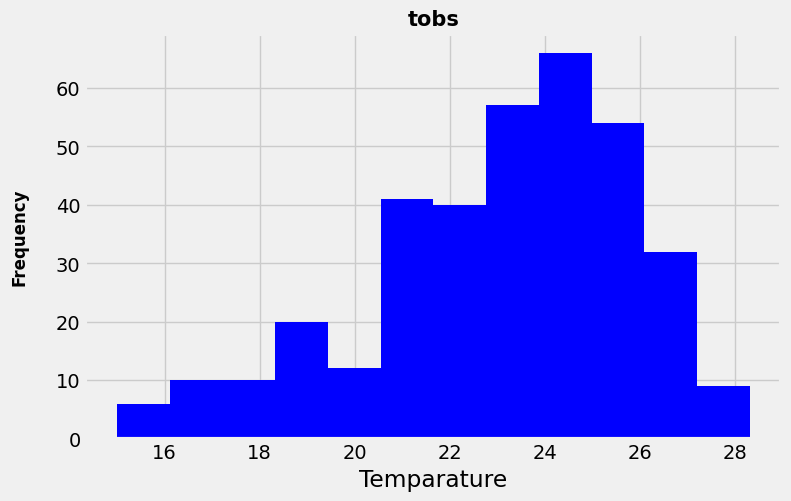

In [24]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

results_date=session.query(Measurement.date).order_by(Measurement.date.desc()).\
             filter(Measurement.station==station_Measurment_join[0][0]).first()
str_date=list(np.ravel(results_date))[0]
latest_date=dt.datetime.strptime(str_date,"%Y-%m-%d")
year_back=latest_date-dt.timedelta(days=366)

results_temp=session.query(Measurement.tobs).\
             filter(Measurement.station==station_Measurment_join[0][0]).\
             filter(Measurement.date>=year_back).all()
df_results=pd.DataFrame(results_temp)


#Plotting Histogram
hist = df_results['tobs'].hist(bins=12,figsize=(8,5), color='b', zorder=2)

# Remove title
hist.set_title("tobs",weight='bold', size=15)

# Set y-axis label
hist.set_ylabel("Frequency", labelpad=20, weight='bold', size=12)

hist.set_xlabel("Temparature")

plt.show()


# Close Session

In [25]:
# Close Session
session.close()